In [1]:
import sys
sys.path.append("..")

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from herec.reader import *

In [2]:
readers = {
    "ML100K_IMPLICIT": ML100K_IMPLICIT(),
    "ML1M_IMPLICIT": ML1M_IMPLICIT(),
    "DIGINETICA": DIGINETICA(),
    "Twitch100K": Twitch100K(),
}

## Basic Staristics

In [3]:
def giniCoefficient(values):

    # Setup
    values = np.array(list(sorted(values)))
    n = len(values)

    # Plot Lorenz Curve
    # fig, ax = plt.subplots(figsize=(2.5, 2.5))
    # ax.plot(np.arange(1, len(values)+1), values.cumsum() / values.sum())
    # plt.show()

    # Gini Coefficient
    return (2 * np.sum(values * np.arange(1, n+1))) / (n * values.sum()) - (n + 1) / n

ML100K_IMPLICIT
User #: 702.0
Item #: 1359.3333333333333
Interaction #: 38570.0
Density #: 0.04053816912673252


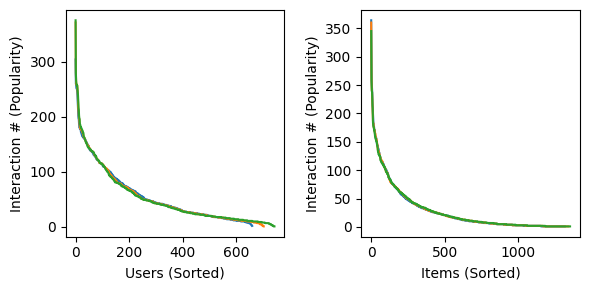

Novelty: 3.7742499619153285
Gini Coefficient: 0.6484356706470668


/tmp/ipykernel_744284/1422610181.py:39: RuntimeWarning: divide by zero encountered in log2
  score = np.array([(- np.log2([p[itemId] for itemId in trueIdList if itemId != -1])).mean() for trueIdList in DATA[seed]["df_EVALUATION"]["true_item_ids"].tolist()])


---

ML1M_IMPLICIT
User #: 4961.666666666667
Item #: 3477.6666666666665
Interaction #: 418113.6666666667
Density #: 0.024232070890942915


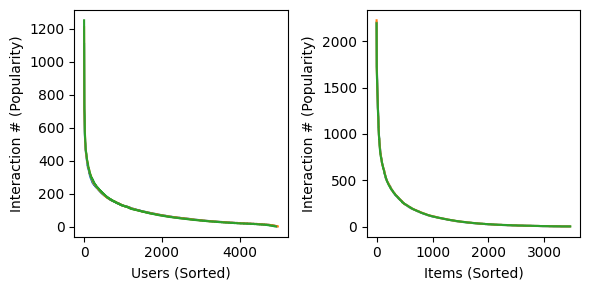

Novelty: 4.289284327446662
Gini Coefficient: 0.6971255477990329


---

DIGINETICA
User #: 85177.33333333333
Item #: 68932.33333333333
Interaction #: 304132.6666666667
Density #: 5.180394977772257e-05


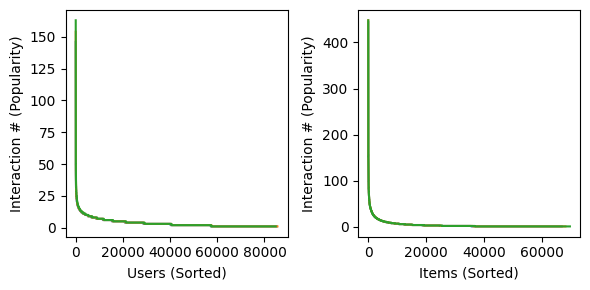

Novelty: 13.255884798366237
Gini Coefficient: 0.6205585876504971


---

Twitch100K
User #: 82509.33333333333
Item #: 73097.66666666667
Interaction #: 428563.6666666667
Density #: 7.105613361298147e-05


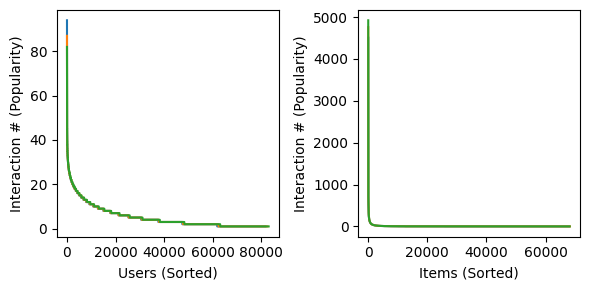

Novelty: 10.111544727448434
Gini Coefficient: 0.7811403376416693


---

In [4]:
for datasetName, reader in readers.items():
    
    print(datasetName)
    DATA = [reader.get(seed, "test") for seed in range(3)]

    # Basic Statistic
    userNum = np.array([DATA[seed]["user_num"] for seed in range(3)])
    print("User #:", np.mean(userNum))
    itemNum = np.array([DATA[seed]["item_num"] for seed in range(3)])
    print("Item #:", np.mean(itemNum))
    interactionNum = np.array([DATA[seed]["df_TRAIN"].height for seed in range(3)])
    print("Interaction #:", np.mean(interactionNum))
    density = interactionNum / (userNum * itemNum)
    print("Density #:", np.mean(density))

    # User/Item Popularity
    fig, ax = plt.subplots( 1, 2, figsize=(6, 3) )
    plt.subplots_adjust(wspace=0.4)
    for seed in range(3):
        values = DATA[seed]["df_TRAIN"].get_column("user_id").value_counts().sort("count", descending=True).get_column("count")
        ax[0].plot( range(len(values)), values )
        ax[0].set_xlabel("Users (Sorted)")
        ax[0].set_ylabel("Interaction # (Popularity)")
        values = DATA[seed]["df_TRAIN"].get_column("item_id").value_counts().sort("count", descending=True).get_column("count")
        ax[1].plot( range(len(values)), values )
        ax[1].set_xlabel("Items (Sorted)")
        ax[1].set_ylabel("Interaction # (Popularity)")
    plt.tight_layout()
    plt.show()

    # Novelty
    novelty = []
    for seed in range(3):
        p = DATA[seed]["df_TRAIN"].group_by("item_id").count().with_columns(
            pl.col("count") / DATA[seed]["df_TRAIN"].get_column("user_id").n_unique()
        )
        p = dict(zip(*p))
        p = {itemId: (p[itemId] if itemId in p.keys() else 0) for itemId in range(DATA[seed]["item_num"])}
        score = np.array([(- np.log2([p[itemId] for itemId in trueIdList if itemId != -1])).mean() for trueIdList in DATA[seed]["df_EVALUATION"]["true_item_ids"].tolist()])
        novelty.append( score[score != np.inf].mean() )
    print("Novelty:", np.mean(novelty))

    # Gini Coefficient
    gini = np.array([giniCoefficient( DATA[seed]["df_TRAIN"].group_by("item_id").count().get_column("count") ) for seed in range(3)])
    print("Gini Coefficient:", np.mean(gini))

    display(Markdown('---'))